In [2]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as kl
import option_pricing.option_pricing as options
import pprint as pp
import os

print( tf.__version__ )

2.2.0


In [3]:
    # Read dataset
    dataset = pd.read_csv( '/Users/joshua/source/golang/src/github.com/obolary/lambda-asset-corpus/ALL/XAUUSD_1M_ALL.csv' , ';', names=[ 'date-time','O','H','L','C','V' ] )
    dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y-%m-%d')
    dataset = dataset.set_index( ['date-time'] )

    # Calculate Historical Velocity
    close = dataset['C']
    daily = close.groupby( by=close.index.date ).apply( lambda x: x[0] )
    hist_vol_offset = 0.125
    hv = daily.pct_change().rolling( 365 ).std() * ( 252 ** 0.5 ) + hist_vol_offset
    hv[0:365] = np.arange( start=0.2, stop=hv[365], step=(hv[365]-0.2)/365 )

In [4]:
# Defines generators for each input to avoid loading large chunks into RAM, and to speed up computation
def send_days( ):
    date = dataset.index[0] + pd.Timedelta( '14 days' )
    for i in range( len( dataset[ 'C' ] ) ):
        days = (date - dataset.index[i]).days 
        if days <= 3:
            date = dataset.index[i] + pd.Timedelta( '14 days' )
        yield days / 365

def send_strike( ):
    for closes in dataset[ 'C' ]:
        yield 5 * np.round( ( np.ceil( closes + ( 5 / 2 ) ) ) / 5 )

def send_hv( ):
    for date in dataset[ 'C' ].index:             
        yield hv[ datetime.date( date.year, date.month, date.day ) ]

def send_option_price( ):
    days   = send_days()
    kind   = 'c'
    vol    = send_hv()
    close  = send_close()
    strike = send_strike()

    # Calculates option price using Blacks Scholes
    for closes in dataset[ 'C' ]:
        yield options.american( kind, next( close ), next(strike), next(days), 0.01, 0.0, next(vol) )[0]
        
def send_close():
    for close in dataset[ 'C' ]:
        yield close

def send_data( batch_size= 24 ):
    done = False
    while not done:
        opt_price = send_option_price( )
        vol = send_hv( )
        days = send_days( )
        closes = send_close( )
        strike = send_strike( )

        x = np.empty( [ batch_size, 4] )
        y = np.empty( [batch_size, 1] )

        for _ in range( int( len( dataset[ 'C' ] ) / batch_size ) ):
            # Loads input and expected outputs into a batch
            for i in range( batch_size ):
                x[i][0] = next(closes)
                x[i][1] = next(days)
                x[i][2] = next(vol)
                x[i][3] = next(strike)
                y[i][0] = next(opt_price)
  
            yield ( tf.convert_to_tensor(x[:]), tf.convert_to_tensor(y[:]) )


In [5]:
model = tf.keras.Sequential([
                             kl.Dense(1024, activation= 'linear'),
                             kl.Dense(512, activation= 'sigmoid'),
                             kl.Dense(400, activation= 'linear'),
                             kl.Dense(32, activation= 'sigmoid'),
                             kl.Dense(1, activation= 'linear')
                            ])

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate= 0.0001))

# Defines a checkpoint file to store weights in to resume training / save the current state of the model
checkpoint_path = "training_1/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
# Loads saved weights to the model to resume training / prediction
#model.load_weights( checkpoint_path )

In [6]:
data = send_data()
model.fit(
            x= data, 
            epochs= 250, 
            verbose= True, 
            use_multiprocessing= False, 
            steps_per_epoch= 150, 
            callbacks= cp_callback
        )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/250
150/150 [==============================] - 5s 35ms/step - loss: 72.7571
Epoch 2/250
150/150 [==============================] - 5s 36ms/step - loss: 45.7334
Epoch 3/250
150/150 [==============================] - 5s 35ms/step - loss: 11.0243
Epoch 4/250
150/150 [==============================] - 5s 35ms/step - loss: 61.7076
Epoch 5/250
150/150 [==============================] - 5s 36ms/step - loss: 23.4024
Epoch 6/250
150/150 [==============================] - 5s 35ms/step - loss: 23.7205
Epoc

KeyboardInterrupt: 

In [7]:
# Gets a sample of inputs and outputs
batch_size = 1000

y_values = np.fromiter( send_option_price(), dtype= np.float32, count= batch_size )
days = np.fromiter( send_days(), dtype= np.float32, count= batch_size )
vol = np.fromiter( send_hv(), dtype= np.float32, count= batch_size )
strike = np.fromiter( send_strike(), dtype= np.float32, count= batch_size )

data = np.empty( [batch_size, 4] )
for i in range( batch_size ):
    data[i][0] = dataset['C'][i]
    data[i][1] = days[i]
    data[i][2] = vol[i]
    data[i][3] = strike[i]

print( data )
# Pred
pred = np.asarray( np.squeeze( model.predict_on_batch( x= data )))


[[9.29600000e+02 3.83561626e-02 2.00000003e-01 9.35000000e+02]
 [9.26050000e+02 3.56164388e-02 2.00000003e-01 9.30000000e+02]
 [9.25900000e+02 3.56164388e-02 2.00000003e-01 9.30000000e+02]
 ...
 [9.21400000e+02 3.56164388e-02 2.00205848e-01 9.25000000e+02]
 [9.20730000e+02 3.56164388e-02 2.00205848e-01 9.25000000e+02]
 [9.19980000e+02 3.56164388e-02 2.00205848e-01 9.25000000e+02]]


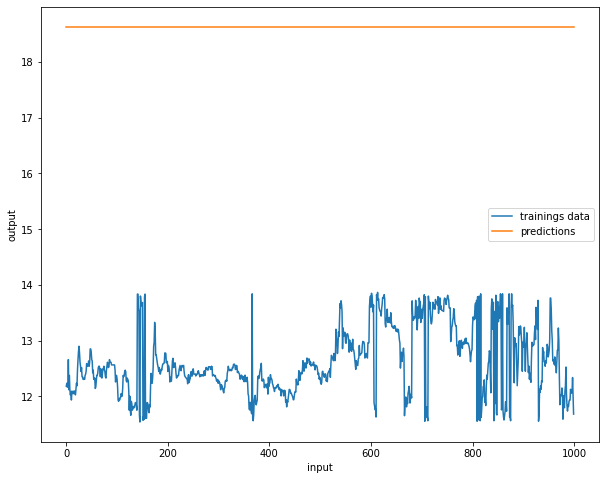

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

plt.xlabel('input')
plt.ylabel("output")

plt.plot( y_values, label="trainings data")
plt.plot( pred, label="predictions")

plt.legend()
plt.show()

In [ ]:
model.summary()